In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd

from shapely.geometry import Point

from pyogrio import read_dataframe, write_dataframe

from sklearn.neighbors import BallTree

import warnings
import seaborn as sns
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [2]:
fp = "dem30_sfl_point.shp"
Geodata0 = read_dataframe(fp)
print( Geodata0.columns )

Geodata01 = Geodata0.copy()

Index(['pointid', 'grid_code', 'category1', 'category2', 'category3',
       'category4', 'category5', 'geometry'],
      dtype='object')


In [7]:
Geodata0['x'] = Geodata0.geometry.get_coordinates().x
Geodata0['y'] = Geodata0.geometry.get_coordinates().y

In [8]:
Geodata0['dem_03mslr'] = Geodata0['grid_code'] + 0.3

In [9]:
Geodata0['cate1tot'] = Geodata0['category1'] + Geodata0['grid_code']
Geodata0['cate2tot'] = Geodata0['category2'] + Geodata0['grid_code']
Geodata0['cate3tot'] = Geodata0['category3'] + Geodata0['grid_code']
Geodata0['cate4tot'] = Geodata0['category4'] + Geodata0['grid_code']
Geodata0['cate5tot'] = Geodata0['category5'] + Geodata0['grid_code']

In [10]:
print( Geodata0['category1'] .unique() )
print( Geodata0.shape )


[-9999    10    11     9     8     7     6     5     4     2     1     3
    12]
(9427489, 16)


In [11]:

Geodata1 = Geodata0[ Geodata0['category1'] < 0 ]
Geodata2 = Geodata0[ Geodata0['category1'] > 0 ]


In [12]:
print( Geodata1.shape )
print( Geodata2.shape )

(6719568, 16)
(2707921, 16)


In [13]:
# Convert the geometry of your first GeoDataFrame to a numpy array of coordinates
coords_gdf1 = np.array(list( Geodata1.geometry.apply(lambda geom: (geom.y, geom.x))))
coords_gdf2 = np.array(list( Geodata2.geometry.apply(lambda geom: (geom.y, geom.x))))


In [14]:
tree = BallTree(coords_gdf2, metric='haversine')
distances, indices = tree.query(coords_gdf1, k=1)


In [46]:
# Add the distance and index of the nearest neighbor to gdf1
Geodata1['nnidx'] = indices.flatten()
Geodata1['dist_near'] = distances.flatten()

# Convert distance from radians to kilometers (assuming Earth radius of 6,371 km)
Geodata1['dist_near_km'] = Geodata1['dist_near'] * 6371

# If you need the actual data from gdf2, you can merge or map it based on the index
# For example, to add the geometry of the nearest neighbor in gdf2 to gdf1
Geodata1['cate1tot'] = Geodata1['nnidx'].apply(lambda x: Geodata2.iloc[x].cate1tot)


In [47]:
Geodata1['cate1tot']

0          11
1          11
2          11
3          11
4          11
           ..
9427484     8
9427485     8
9427486     8
9427487     8
9427488     8
Name: cate1tot, Length: 6719568, dtype: int64

<Axes: >

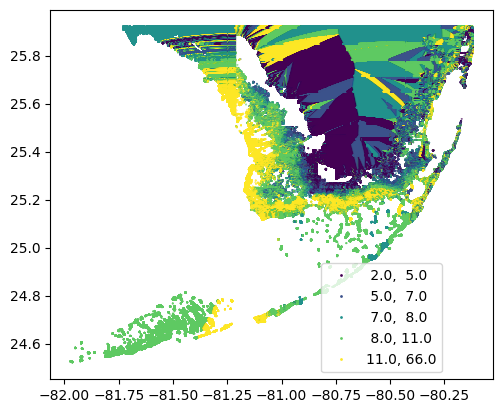

In [50]:
Geodata1.plot(column= 'cate1tot', 
             scheme="Quantiles", k = 5,
            #scheme = "user_defined", k = 5,
            #classification_kwds = {'bins':[0, 1, 2, 12]},
             legend = True , markersize= 0.1,
             legend_kwds = { 'loc':'lower right', 
                            'bbox_to_anchor':(0.9, 0.0), 
                            'fmt':'{:.1f}',
                            'markerscale': 0.2, 
                            'title_fontsize':'large', 
                            'fontsize':'medium'} ) 

<Axes: >

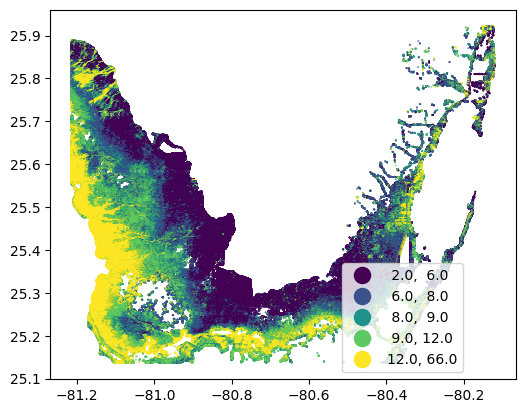

In [51]:
Geodata2.plot(column= 'cate1tot', 
             scheme="Quantiles", k = 5,
            #scheme = "user_defined", k = 5,
            #classification_kwds = {'bins':[0, 1, 2, 12]},
             legend = True , markersize= 0.1,
             legend_kwds = { 'loc':'lower right', 
                            'bbox_to_anchor':(0.9, 0.0), 
                            'fmt':'{:.1f}',
                            'markerscale': 1.26, 
                            'title_fontsize':'large', 
                            'fontsize':'medium'} ) 

In [15]:
column_names = [ 'category1', 'category2', 'category3', 'category4', 'category5' ]

column_names2 = [ 'cate1tot', 'cate2tot', 'cate3tot', 'cate4tot', 'cate5tot' ]


idx = 0
for columni in column_names:
    print( columni )
    Geodata1 = Geodata0[ Geodata0[ columni ] < 0 ]
    Geodata2 = Geodata0[ Geodata0[ columni ] > 0 ]

    coords_gdf1 = np.array(list( Geodata1.geometry.apply(lambda geom: (geom.y, geom.x))))
    coords_gdf2 = np.array(list( Geodata2.geometry.apply(lambda geom: (geom.y, geom.x))))

    tree = BallTree(coords_gdf2, metric='haversine')
    distances, indices = tree.query(coords_gdf1, k=1)
    text0 = 'nnidx'
    colnamei0 = f"{text0}{idx}" 
    # Add the distance and index of the nearest neighbor to gdf1
    Geodata1[colnamei0] = indices.flatten()
    #Geodata1['dist_near'] = distances.flatten()
    # Convert distance from radians to kilometers (assuming Earth radius of 6,371 km)
    #Geodata1['dist_near_km'] = Geodata1['dist_near'] * 6371
    # If you need the actual data from gdf2, you can merge or map it based on the index
    # For example, to add the geometry of the nearest neighbor in gdf2 to gdf1
    text1 = 'cate'
    text2 = 'tot'
    colnamei = f"{text1}{idx}{text2}" 
    column2i = column_names2[ idx ]
    Geodata1[colnamei] = Geodata1[colnamei0].apply(lambda x: Geodata2.iloc[x][ column2i ])
    resulti = pd.concat( [ Geodata1, Geodata2 ] )

    
    Geodata01 = pd.merge( Geodata01, resulti[ ['pointid', colnamei ] ], on='pointid', how='right')
    idx = idx + 1




category1
category2
category3
category4
category5


In [16]:
Geodata01.head()

,pointid,grid_code,category1,category2,category3,category4,category5,geometry,cate0tot,cate1tot,cate2tot,cate3tot,cate4tot
0,38683802,1,-9999,-9999,-9999,-9999,-9999,POINT (-81.94986 24.58292),11.0,15,18,23,24
1,38691826,1,-9999,-9999,-9999,-9999,-9999,POINT (-81.95125 24.58264),11.0,15,18,23,24
2,38691827,2,-9999,-9999,-9999,-9999,-9999,POINT (-81.95097 24.58264),11.0,15,18,23,24
3,38691828,2,-9999,-9999,-9999,-9999,-9999,POINT (-81.95069 24.58264),11.0,15,18,23,24
4,38691829,3,-9999,-9999,-9999,-9999,-9999,POINT (-81.95042 24.58264),11.0,15,18,23,24


In [17]:
Geodata01.cate0tot.unique()

array([11.,  9., 14., 18., 17., 16., 15., 13., 12., 10., 19., 20.,  8.,
        7.,  6., 21., 22., 23., 24., 29., 28.,  4.,  5., 25., 26., 27.,
        3., 30., 32., 33.,  2., 31., 34., 40., 38., 45., 52., 36., nan,
       35., 53., 59., 37., 41., 44., 51., 50., 55., 47., 46., 43., 60.,
       66.])

In [18]:
Geodata_select = gpd.GeoDataFrame( Geodata01 , geometry = 'geometry', crs="EPSG:4326")
write_dataframe( Geodata_select, path= r'dem30_sfl_poi_updated.shp', driver='ESRI Shapefile' )